In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from matplotlib.colors import ListedColormap

## Problem: Travelling Salesman Problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

In [2]:
### nice plots

import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'

## Read data for analysis

In [3]:
class Datas():
    def __init__(self, bits_idx_list, n_temp_scalers, M_strats, n_eta_runs, n_samples_SA = 128):
        N_cities = np.arange(2, 6)
        vseeds = np.arange(42, 43)
        self.Nc = N_cities[bits_idx_list]
        self.bits = N_cities[bits_idx_list]**2
        self.vseeds = vseeds
        self.n_vseeds = len(vseeds)
        self.M_strategies = M_strats # index: 0->"feasibility", 1->"optimality"
        self.temperature_scalers = [1, 10, 100]
        self.temperature_base = 1e4
        self.temperatures_labels = ["$10^4$", "$10^5$", "$10^6$"] # = temp_base * temp_scalers
        self.Gibbs_samples = 1000

        self.M_star = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers, len(M_strats), n_eta_runs))
        self.M_L1 = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_required = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_guaranteed = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_effective = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers, len(M_strats), n_eta_runs))
        self.temperature = np.ndarray((len(bits_idx_list), len(vseeds), n_temp_scalers))
        self.E_f = np.ndarray((len(bits_idx_list), len(vseeds)))

In [4]:
# change last_Nidx to extend your dataset as you collect more data

last_Nidx = 3
N_idxs = np.arange(last_Nidx+1)
n_temp_scalers = 3
M_strategies = ["feasibility", "optimality"]
n_eta_runs = 3
data = Datas(N_idxs, n_temp_scalers, M_strategies, n_eta_runs)

directory = "../data/Gibbs_TSP_circle/"

for N_idx in N_idxs: # if N_idxs start from 0. Else, write "for N_idx_idx, N_idx in enumerate(N_idxs):"
    filename = directory + f"results-Nc={data.Nc[N_idx]}.txt"
    file = open(filename, "rb")
    D = pickle.load(file)
    file.close()

    assert len(D.keys()) == len(data.vseeds)
    for seed_idx, seed in enumerate(D):
        data.E_f[N_idx, seed_idx] = D[seed]["E_f"]

        assert len(D[seed].keys()) == n_temp_scalers + 1 # the +1 is for E_f
        for temp_idx, temp_scaler in enumerate(list(D[seed])[1:]):
            data.temperature[N_idx, seed_idx, temp_idx] = D[seed][temp_scaler]["temperature"]

            assert len(D[seed][temp_scaler].keys()) == len(M_strategies) + 1  # the +1 is for temperature
            for M_strat_idx, M_strat in enumerate(list(D[seed][temp_scaler])[1:]):
                assert len(D[seed][temp_scaler][M_strat].keys()) == n_eta_runs
                for eta_run_idx, eta_req in enumerate(D[seed][temp_scaler][M_strat]):
                    data.M_star[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["M_star"]
                    data.M_L1[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["M_L1"]
                    data.eta_required[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_required"]
                    data.eta_guaranteed[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_guaranteed"]
                    data.eta_effective[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_effective"]

## $\eta_{eff} / \eta_{guar} (\beta_f scaler)$ for different $\eta_{req}$ and feas/opt $M$ strategies

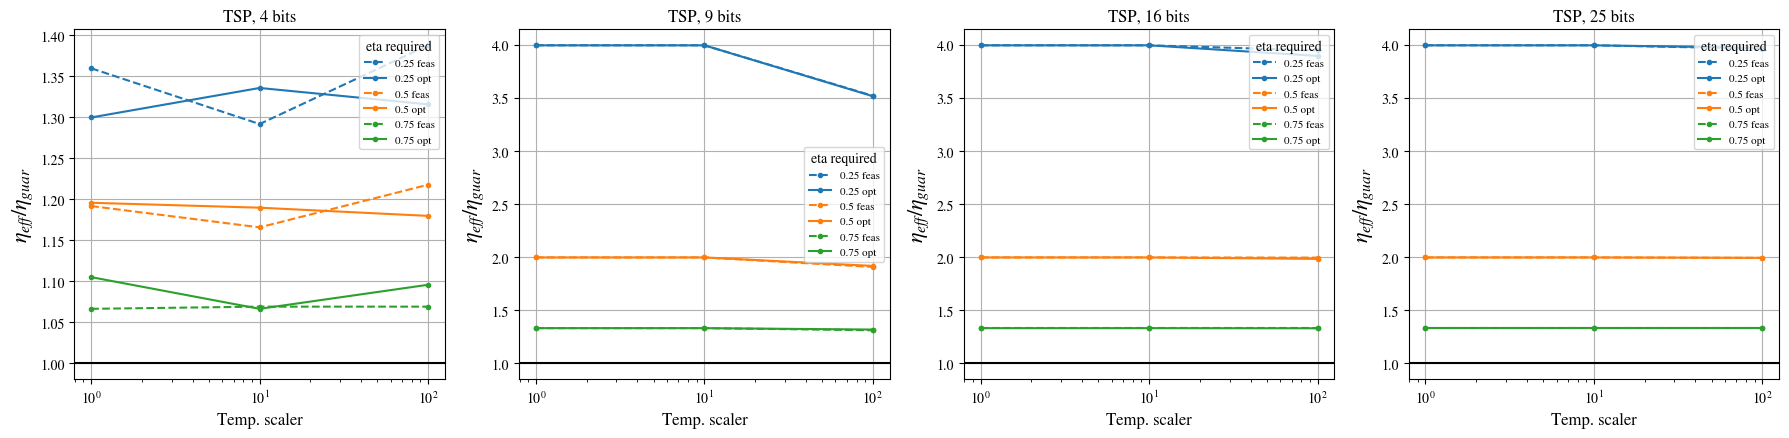

In [5]:
fig = plt.figure(figsize=(22,10))

for N_idx in N_idxs:
    ratios = np.mean( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    ratios_std = np.std( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    
    ax = fig.add_subplot(2,4,N_idx+1)
    ax.set_xlabel('Temp. scaler', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.temperature_scalers, ratios[:, 0, eta_run_idx], "--", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " feas")
        ax.plot(data.temperature_scalers, ratios[:, 1, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " opt")
    ax.set_xscale("log")
    ax.set_title(f"TSP, {data.Nc[N_idx]**2} bits")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

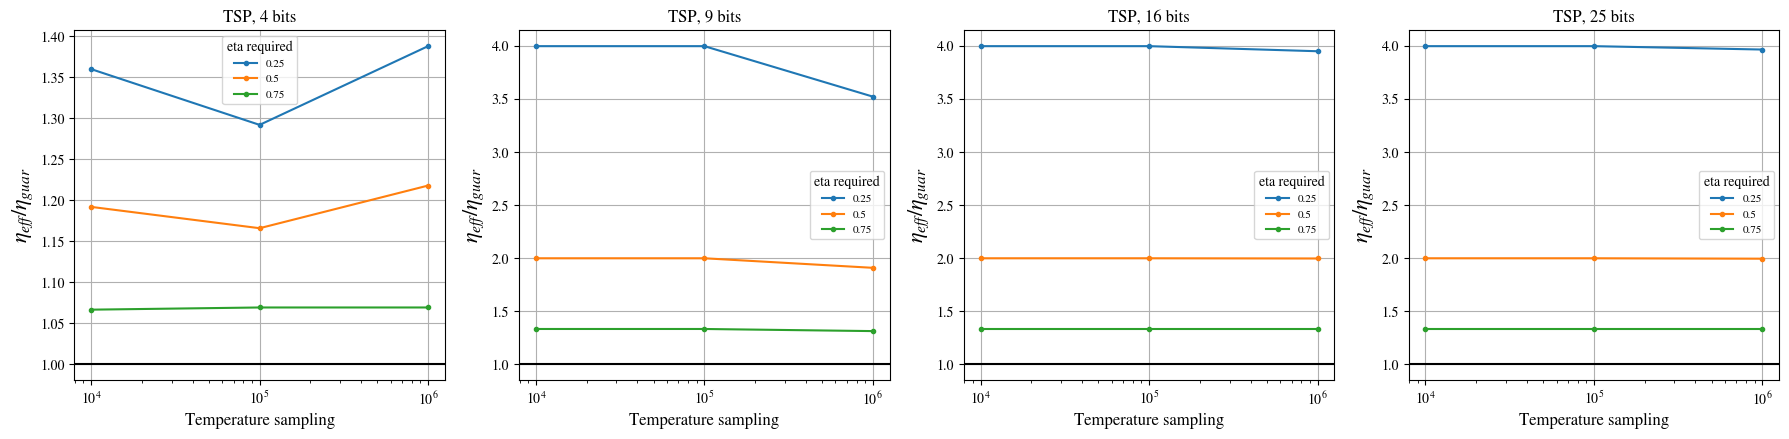

In [6]:
Mstrat = 0

fig = plt.figure(figsize=(22,10))
for N_idx in N_idxs:
    ratios = data.eta_effective[N_idx, :, :, Mstrat, :] / data.eta_guaranteed[N_idx, :, :, Mstrat, :] # [seed_idx, temp_idx, eta_run_idx]
    ax = fig.add_subplot(2,4,N_idx+1)
    ax.set_xlabel('Temperature sampling', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        for seed_idx in np.arange(data.n_vseeds):
            if seed_idx == 0:
                ax.plot(data.temperature[N_idx, seed_idx, :], ratios[seed_idx, :, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
            else:
                ax.plot(data.temperature[N_idx, seed_idx, :], ratios[seed_idx, :, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}")
    ax.set_xscale("log")
    ax.set_title(f"TSP, {data.Nc[N_idx]**2} bits")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

## $\eta_{eff} / \eta_{guar} (n_{bits})$

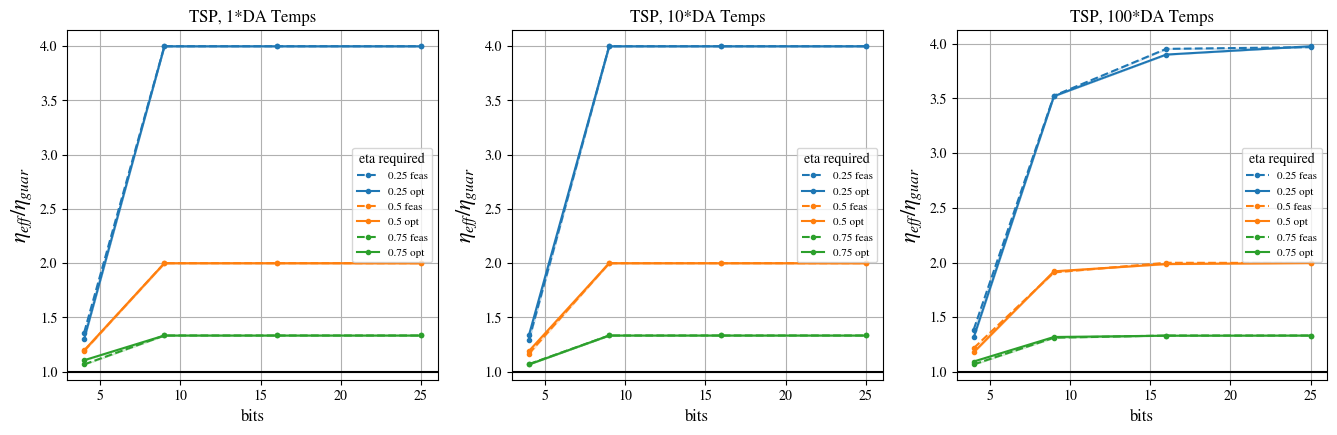

In [7]:
fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    ratios = np.mean( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    ratios_std = np.std( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, ratios[:, 0, eta_run_idx], "--", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " feas")
        ax.plot(data.bits, ratios[:, 1, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " opt")
        ax.fill_between(data.bits, ratios[:, 0, eta_run_idx] - ratios_std[:, 0, eta_run_idx], ratios[:, 0, eta_run_idx] + ratios_std[:, 0, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
        ax.fill_between(data.bits, ratios[:, 1, eta_run_idx] - ratios_std[:, 1, eta_run_idx], ratios[:, 1, eta_run_idx] + ratios_std[:, 1, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    #ax.set_xscale("log")
    ax.set_title(f"TSP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

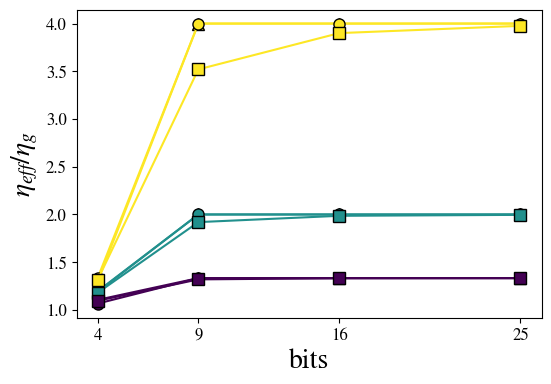

In [ ]:
M_strategy = "optimality" # "feasibility" or "optimality"
if M_strategy == "feasibility":
    M_strat_idx = 0
    M_strat_short = "feas"
else:
    M_strat_idx = 1
    M_strat_short = "opt"

markers = ["^", "o", "s"]

colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, n_temp_scalers))) 

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'bits', fontsize = 20)
ax.set_ylabel(r'$\eta_{eff} / \eta_{g}$', fontsize = 20)
ax.set_xticks(data.bits)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)  

for temp_idx in range(n_temp_scalers):
    ratios = np.mean( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    ratios_std = np.std( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, ratios[:, M_strat_idx, eta_run_idx], "-", marker = markers[temp_idx], markersize = 8, color = discr_colors.colors[eta_run_idx], markeredgecolor="black",
                        label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + f" ; {data.temperature_scalers[temp_idx]}")

# # ---- Concise legend ----
# eta_handles = [Line2D([0], [0], color=c, lw=2, label=f'{eta}') for c, eta in zip(discr_colors.colors, data.eta_required[0,0,0,0])]
# temp_handles = [Line2D([0], [0], color="w", markersize = 8,  markeredgecolor = "k", marker=m, lw=0, label=T) for m, T in zip(markers, data.temperatures_labels)]
# all_handles = eta_handles + temp_handles
# all_labels  = [h.get_label() for h in all_handles]
# ax.legend(handles=all_handles, labels=all_labels, title=r"      $\eta_{r}$            Temp.", title_fontsize=14, fontsize=13, loc="center right", ncol=2)
# # --------
#ax.legend(title = r"$\eta$ required ; $\beta$ scaler", fontsize = 10, loc='center right')
#ax.grid()
if M_strategy == "feasibility":
    ax.set_title(f"circle TSP", fontsize = "18")
plt.show()
plt.show()

#fig.savefig(f"../plots_paper/eta_ratio/Gibbs_TSP_circle_{M_strat_short}.pdf", bbox_inches='tight', format="pdf")

## $log( M_{\ell_1} / M^*)(n_{bits})$ for different temperatures

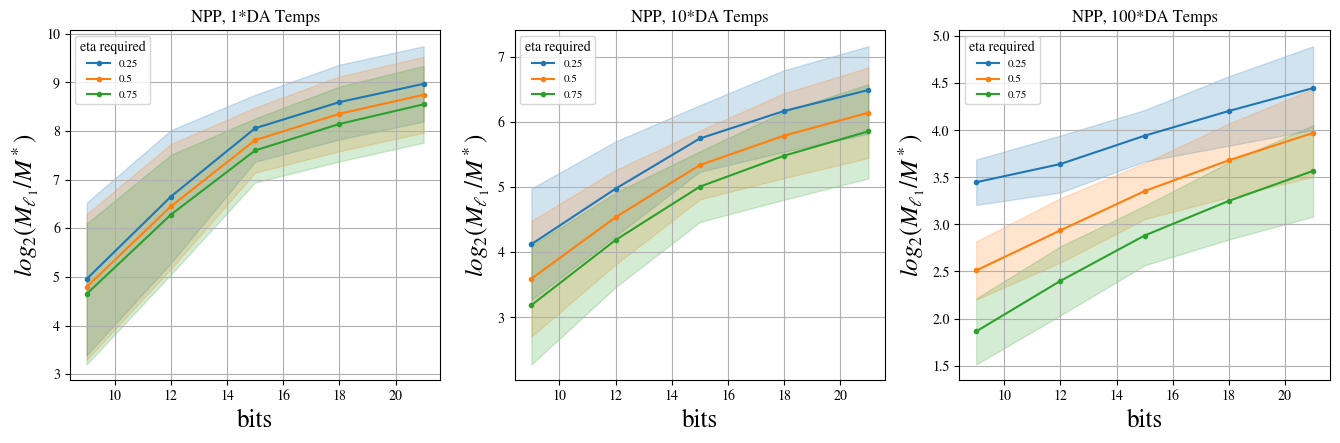

In [37]:
Mstrat = 0

fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
    logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 18)
    ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
        ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    #ax.set_xscale("log")
    ax.set_title(f"NPP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

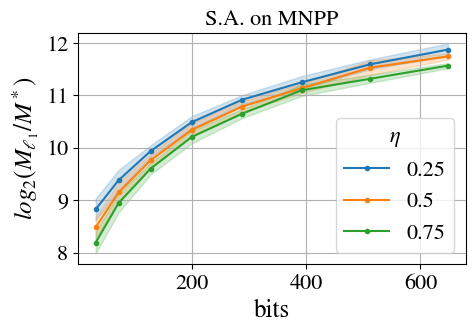

In [48]:
Mstrat = 0
temp_idx = 1

logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel('bits', fontsize = 18)
ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

for eta_run_idx in np.arange(n_eta_runs):
    ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
    ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
#ax.set_xscale("log")
ax.set_title(f"S.A. on MNPP", fontsize = 16)
ax.legend(title = r"$\eta$", fontsize = 16, loc='best', title_fontsize = 16)
ax.grid()
ax.tick_params(axis='both', labelsize=16)
plt.show()

# fig.savefig("plots/scale_niters_SA", bbox_inches='tight')
